<div style="width:90%; text-align:center; border-width: 0px; display:block; margin-left:auto; margin-right:auto; background-color:off white; position: relative;">
  <div class="alert alert-block alert-success" style="text-align:center; color:white; background-color:#1e2124 !important;">
    <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_unb.png" style="width: 200px; opacity:0.85;">
    <h1>Universidade de Brasília</h1>
    <h2>Instituto de Física</h2>
    <hr style="width:44%;border:1px solid white;">
    <h3>Mini Curso de Inteligência Artificial para a Física</h3> 
    <h4>Henrique de Oliveira Noronha</h4>
    <hr style="width:44%;border:1px solid white;">
  </div>
  <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_if.png" style="position: absolute; bottom: 20px; left: 40px; width: 100px;">
</div>


# **➲ Aula 2 - Abordando Séries Temporais**

## Motivação Física
---
É muito comum nos depararmos com problemas de evolução temporal de algo na física, como por exemplo, o movimento de uma partícula, ou a variação da temperatura de um objeto. Por isso, é importante termos ferramentas para tratar esses problemas. Como vimos na aula anterior, com o oscilador harmônico, o modelo de camadas densas não foi muito bom para modelar aquele problema. Porém, o problema em si foi mal formulado, queríamos que a rede neural conseguisse prever a posição do oscilador daqui a 20 segundos só fornecendo os dados de posição inicial e velocidade. É uma tarefa muito difícil, tome por exemplo um goleiro, ele não preve onde a bola vai chegar no gol somente a partir do chute inicial, ele constantemente analisa a trajetória da bola para determinar com precisão onde ela vai. Isso pode ser comprovado pela dificuldade de pegar um pênalti, a quantidade de informação para o goleiro analisar é muito menor do que um chute à distância.

Por essa razão, modelamos problemas de séries temporais alimentando o modelo com N intervalos de tempo e pedimos para ele prever os próximos M intervalos de tempo. Vamos verificar essa abordagem novamente com o oscilador harmônico:

In [38]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten

In [91]:
N_intervalos = 10


def criar_sequencias(X, N_intervalos):
    sequencias_entrada = []
    sequencias_saida = []
    L,dim = X.shape
    for i in range(L-N_intervalos):
        entrada = X[i:i+N_intervalos,:]
        saida = X[i+N_intervalos:i+N_intervalos+1,:]
        sequencias_entrada.append(entrada)
        sequencias_saida.append(saida)
    return np.array(sequencias_entrada), np.squeeze(np.array(sequencias_saida),axis=1) # Squeeze para corrigir o shape das saídas para ser (batches,features), sem ele fica (batches,1,features)


In [93]:
# Definir a função para resolver com ode int
def oscilador_harmonico(y,t,k,m):
    x = y[0]
    v = y[1]
    dvdt = -k/m*x
    return [v,dvdt]

# Fixar semente para obter mesmos resultados
np.random.seed(42)
condicoes_iniciais = [2.4,0.5]
dt = 0.1
t = np.arange(0,10+dt,dt)
k = 0.5
m = 1.0
solucao = odeint(oscilador_harmonico, condicoes_iniciais, t, args=(k,m))
solucao[:,1] = solucao[:,1]*m #momentos

#Criar sequencias com o total de dados

entradas_totais,saidas_totais = criar_sequencias(solucao,10)

#Pegar somente 45 dessas sequencias para treinar o modelo, aproximadamente 50% dos dados, assim como anteriormente

indices = np.arange(0,len(saidas_totais)) # Subtrair 2 pois queremos evitar escolher o último
indices = np.random.choice(indices,45,replace=False) # Escolher 50 aleatorios, sem ser iguais (replace=False)
entradas_treinamento, saidas_treinamento = entradas_totais[indices],saidas_totais[indices]

In [235]:
modelo = Sequential([Input((10,2)),
                     Flatten(),
                     Dense(32,activation="tanh"),
                     Dense(32,activation="tanh"),
                     Dense(2,activation="linear")])

modelo.compile(optimizer="adam",loss="mse",metrics=["mae"]) # Compilar o modelo com ADAM, função de perda MSE e vamos observar a MAE (erro absoluto médio)

In [236]:
history = modelo.fit(entradas_treinamento,saidas_treinamento,epochs=500, batch_size=25,verbose=0)

Agora com o modelo treinado, vamos prever iterativamente a partir das primeiras 10 posições. O modo que estou fazendo abaixo é meio confuso mas basicamente é só usar o modelo prever a posição após as 10 posicoes iniciais, fazer um novo vetor com as 9 posicoes antigas, tirando o mais antigo, nesse caso, a primeira posição e adicionando a previsão anterior para fazer uma nova previsão e assim sucetivamente.   

In [232]:
previsoes = entradas_totais[0,:,:].tolist() # Transforma as primeiras posicoes em uma lista de posicoes
#Alimentar a rede neural iterativamente a partir da posicao inicial por 190 iterações de dt=0.1s, ou seja, 19s (A entrada cobre o primeiro 1s)
for i in range(190):
    previsao_i = modelo((np.array([previsoes[k][:] for k in range(i,N_intervalos+i)]).reshape(1,N_intervalos,2)),training=False) # Adicionar a previsão nova para os 9 intervalos anteriores para gerar a nova entrada para o modelo prever
    previsoes.append(previsao_i.numpy().tolist()[0])

previsoes = np.array(previsoes)


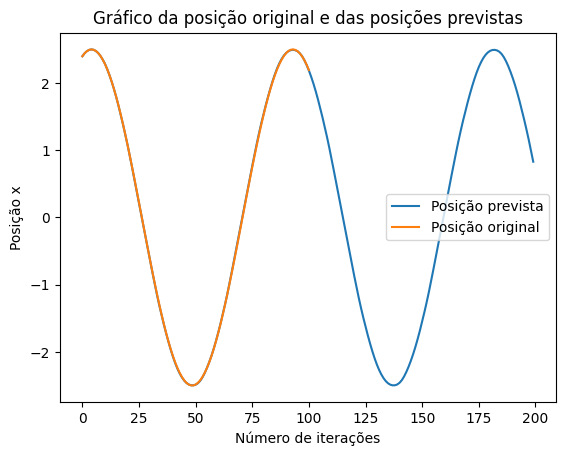

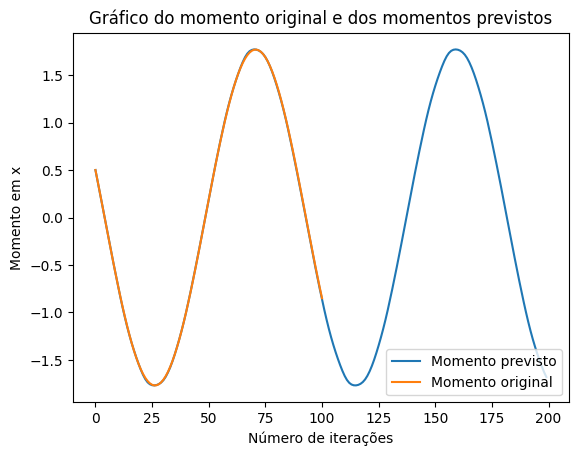

In [233]:
plt.plot(previsoes[:,0], label = "Posição prevista")
plt.plot(solucao[:,0], label="Posição original")
plt.title("Gráfico da posição original e das posições previstas")
plt.ylabel("Posição x")
plt.xlabel("Número de iterações")
plt.legend()
plt.show()

plt.plot(previsoes[:,1], label = "Momento previsto")
plt.plot(solucao[:,1], label = "Momento original")
plt.title("Gráfico do momento original e dos momentos previstos")
plt.ylabel("Momento em x")
plt.xlabel("Número de iterações")
plt.legend()
plt.show()

O resultado é muito melhor! Contudo, para problemas com dependências temporais mais complexas, precisamos incorporar no nosso modelo um mecanismo de memória e que entenda que os dados estão organizados de forma que o passo t dependa do passo t-1. Para isso, temos as **redes neurais recorrentes**. 